# Setup

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn import svm

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In the next cell, we define the environment. Given *n* items and *d* dimensions, we generate a *d*-dimensional vector for each item, uniformly distributed on the *d*-dimensional unit hypersphere centered at the origin. We also generate a *theta* in the same way to represent the user's true preference. We also define some useful functions, including one to find the utility of an item, and one to return the utility of an item with some noise added (for scenario 2). 

In [ ]:
class Environment:
  def __init__(self, n, d):
    self.d = d
    self.n = n
    self.items = self.gen_items()
    self.theta = self.gen_theta()
    self.best = self.gen_best()
    self.max_util = self.gen_max_util()

  def gen_items(self):
    items = np.zeros((self.n, self.d))
    for i in range(self.n):
      for j in range(self.d):
        items[i,j] = np.random.normal(0, 1)
    norms = np.linalg.norm(items, axis = 1)
    return items / norms[:,None]
  
  def gen_theta(self):
    theta1 = np.zeros(self.d)
    for i in range(self.d):
      theta1[i] = np.random.normal(0, 1)
    return theta1 / np.linalg.norm(theta1)

  def item(self, index):
    return self.items[index, :]

  def utility(self, x):
    return np.dot(self.theta,x)

  def util_noisy(self, x):
    return np.dot(self.theta,x) + np.random.normal(0, 0.1)

  def gen_best(self):
    utils = np.matmul(self.items, self.theta)
    return np.argmax(utils)

  def gen_max_util(self):
    return self.utility(self.item(self.best))


# Part 1 Algorithm

In the following cell, we define our algorithm to solve case 1, where whenever we present an item to the user, they give their utility exactly.

In [ ]:
# Algorithm to solve Part 1

def alg1(env):
  n = env.n
  d = env.d

  matrix = np.zeros((d, d))
  utils = np.zeros(d)

  # ask the user to provide utilities for d items
  for i in range(d):
    matrix[i] = env.item(i)
    utils[i] = env.utility(env.item(i))

  # calculate theta
  est_theta = np.linalg.solve(matrix, utils)

  # find the item that has the highest utility
  best_item = -1
  best_util = -1
  for i in range(n):
    curr_util = np.dot(est_theta,env.item(i))
    if curr_util > best_util:
      best_util = curr_util
      best_item = i

  return best_item, best_util


We can vary the number of items and the dimensions, but so long as we have *n* >= *d*, we can solve for theta explicitly and then loop through the items and choose the best one.

In [ ]:
n = 100
d = 5

env = Environment(n, d)

best_item, best_util = alg1(env)

print("Predicted Best Item: ", best_item)
print("Actual Best Item: ", env.best)
print("Difference in utility (best - predicted_best): ", env.max_util-best_util)  


Predicted Best Item:  6
Actual Best Item:  6
Difference in utility (best - predicted_best):  1.1102230246251565e-16


# Part 2 Algorithm

The following cell contains our solution for case 2, where in each interaction, we ask a user for their utility of a particular item, but they respond with some random noise added to the true utility.

In [ ]:
def alg2(env, eps, beta, stop = np.inf, version = 2):
  n = env.n
  d = env.d

  # A is a matrix whose rows are the items chosen at each round
  A = np.zeros((d,d))
  A[0] = env.item(0)
  chosen = [0]

  # Matrix of all items (as rows)
  a = env.items

  # Smart Initialization to maximize smallest eigenvalue of A^TA
  if version == 2:
    # Keep orthonormal basis for subspace spanned by items chosen so far (as rows)
    ortho = np.zeros((d,d))
    ortho[0] = env.item(0)/np.linalg.norm(env.item(0))
    # List of sums for each item, where sum is the norm squared of the projection of the item
    # onto the subspace spanned by items chosen so far minus the norm squared of the item
    sums = [-np.linalg.norm(a[i])**2 for i in range(n)]
    # At each step, choose item with lowest sum
    for m in range(1, d):
      min_sum = float('inf')
      min_item = -1
      sums += (a@ortho[m-1])**2
      for i in range(0, n):
        sum = sums[i]
        # Don't choose an item twice (to avoid singular matrix)
        if (i not in chosen) and sum < min_sum:
          min_sum = sum
          min_item = i
      chosen.append(min_item)
      A[m] = env.item(min_item)
      # Update orthornormal basis
      ortho[m] = A[m] - ortho.T@(ortho@A[m])
      ortho[m] /= np.linalg.norm(ortho[m])
  # Random intialization
  else:
    for m in range(1,d):
      chosen.append(m)
      A[m] = env.item(m)

  C = np.matmul(A.T, A)
  B = np.linalg.inv(C)
  # List of x^TBx for each item x
  denoms = np.einsum('ij,ij->i', a, a@B)
  # Number of interactions with the user so far
  num_iters = d-1

  # Get (noisy) utilities of first d chosen items from the user
  y = np.zeros(d)
  for i in range(d):
    y[i] = env.util_noisy(A[i])
  
  # Heuristic for stopping (e[i] = upper estimate on actual utility of item i minus actual utility of current best item)
  e = np.zeros(n)
  best_e = float('inf')
  for i in range(n):
    e[i] = float('inf')
  

  while best_e > eps and num_iters < stop:
    num_iters += 1
    # Update output of linear regression, our best guess for user's preference
    theta = B @ A.T @ y
    # Get current best item
    x = np.argmax(theta @ env.items.T)
    
    # Update e[i] according to distribution of u(item x) - u(item i) (see paper for derivation/details)
    e = a@theta - theta@env.item(x) + beta*np.sqrt(np.abs(denoms+denoms[x]-2*a@(B@env.item(x))))
    e[x] = -1000000

    # Get worst possible error
    best_e_arg = np.argmax(e)
    best_e = np.max(e)

    # Choose next item to minimize (env.item(best_e_arg) - env.item(x))^T @ B @ (env.item(best_e_arg) - env.item(x)) for next iteration (see paper for derivation/details)
    bad = B @ (env.item(best_e_arg) - env.item(x))
    best_e_arg = np.argmax(np.square(bad @ env.items.T) / (denoms+1))


    # Get (noisy) utility of chosen item from user
    y_prime = env.util_noisy(env.item(best_e_arg))
    y = np.append(y, y_prime)

    # Update A by adding chosen item as a row
    A = np.vstack([A, env.item(best_e_arg).T])
    # Update C = A^TA
    C += np.matmul(np.matrix(env.item(best_e_arg)).T, np.matrix(env.item(best_e_arg)))
    # Update B = (A^TA)^{-1} and denoms = [x^TBx for each item x]
    t = B@env.item(best_e_arg)
    u = np.matrix(t)
    v = 1 + u@env.item(best_e_arg)
    B -= np.matmul(u.T, u) / v
    denoms -= np.square(a@t).T / float(v)
  return [x, env.utility(env.item(x)), num_iters]

The following cell provides naive approaches to solving case 2.

In [ ]:
# This algorithm queries the user's utility for each item and chooses the one 
# with the highest value
# Requires n interactions
def part2Naive(env):
    
    bestutil = -1
    bestarm = -1
    for i in range(env.n):
      currutil = env.util_noisy(env.item(i))
      if (currutil > bestutil):
        bestutil = currutil
        bestarm = i

    return env.utility(env.item(bestarm))

# This algorithm applies the solution from part 1 to part 2
# Requires d interactions
def alg1noisy(env):
  n = env.n
  d = env.d

  matrix = np.zeros((d, d))
  utils = np.zeros(d)

  # ask the user to provide utilities for d items
  for i in range(d):
    matrix[i] = env.item(i)
    utils[i] = env.util_noisy(env.item(i))

  # calculate theta
  est_theta = np.linalg.solve(matrix, utils)

  # find the item that has the highest utility
  best_item = -1
  best_util = -1
  for i in range(n):
    curr_util = np.dot(est_theta,env.item(i))
    if curr_util > best_util:
      best_util = curr_util
      best_item = i

  return best_item, best_util


The following cell provides a graph for comparison of effectiveness in an environment with 500 items and 20 dimensions.

  Algorithm variable  Suboptimality Gap
0     Naive        0           0.154732
1     Naive        0           0.000000
2     Naive        0           0.060215
3     Naive        0           0.063674
4     Naive        0           0.182628
v0iters: 33.128
v2iters: 29.464
naive avg: 0.06506182983785619
part 1 avg: 0.3963676575447847
v0 avg 0.03348489142482592
v1 avg 0.022609874013113117


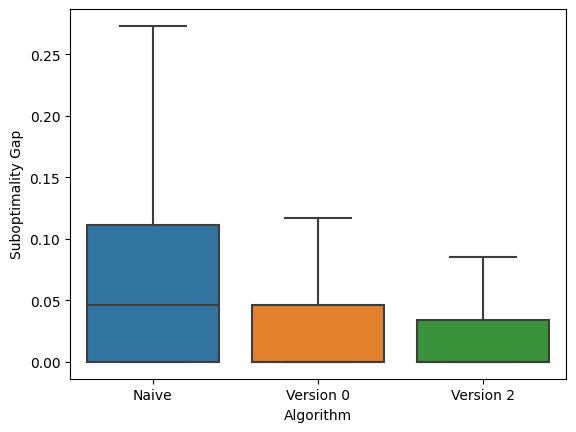

In [ ]:
naiveres = []
alg1res = []
alg2v0res = []
alg2v2res = []
v0iters = 0
v2iters = 0
for i in range(1000):
  env = Environment(500, 20)
  naiveres.append(env.max_util-part2Naive(env))
  alg1arm, alg1util = alg1noisy(env)
  alg1res.append(env.max_util-env.utility(env.item(alg1arm)))
  v0res = alg2(env, .1, .2, 40, 0)
  alg2v0res.append(env.max_util-v0res[1])
  v0iters += v0res[-1]

  v2res = alg2(env, .1, .2, 40, 2)
  alg2v2res.append(env.max_util-v2res[1])
  v2iters += v2res[-1]

v0iters /= 1000
v2iters /= 1000
# https://stackoverflow.com/questions/44552489/plotting-multiple-boxplots-in-seaborn
df1 = pd.DataFrame(naiveres).assign(Algorithm="Naive")

# Part 1 algorithm not graphed because its boxplot is much higher (worse performance) than the others
#df2 = pd.DataFrame(alg1res).assign(Algorithm="Part 1")

df3 = pd.DataFrame(alg2v0res).assign(Algorithm="Version 0")
df4 = pd.DataFrame(alg2v2res).assign(Algorithm="Version 2")

cdf = pd.concat([df1, df3, df4])                          
mdf = pd.melt(cdf, id_vars=['Algorithm'])     
mdf.rename({'value': 'Suboptimality Gap'}, axis=1, inplace=True)
print(mdf.head())

print("v0iters:", v0iters)
print("v2iters:", v2iters)
print("naive avg:", np.mean(naiveres))
print("part 1 avg:", np.mean(alg1res))
print("v0 avg", np.mean(alg2v0res))
print("v1 avg", np.mean(alg2v2res))

ax = sns.boxplot(x="Algorithm", y="Suboptimality Gap", data=mdf, showfliers=False)  # RUN PLOT   
plt.show()




The following cell provides a graph for comparison of effectiveness in an environment with 1000 items and 50 dimensions.

  Algorithm variable  Suboptimality Gap
0     Naive        0           0.000000
1     Naive        0           0.116866
2     Naive        0           0.054436
3     Naive        0           0.193616
4     Naive        0           0.189651
v0iters: 78.606
v2iters: 76.294
naive avg: 0.07868579387442592
part 1 avg: 0.39131333613635993
v0 avg 0.0503614822954541
v1 avg 0.03805497233097086


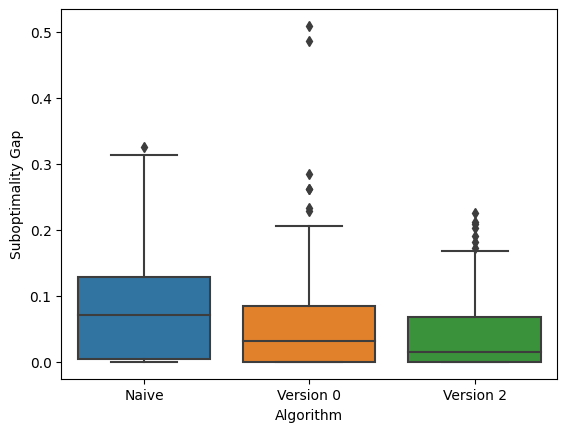

In [ ]:
# Stuff for 1000 items, 50 dim
naiveres = []
alg2v0res = []
alg2v2res = []
v0iters = 0
v2iters = 0
for i in range(500):
  env = Environment(1000, 50)
  naiveres.append(env.max_util-part2Naive(env))
  alg1arm, alg1util = alg1noisy(env)
  alg1res.append(env.max_util-env.utility(env.item(alg1arm)))
  v0res = alg2(env, .1, .2, 80, 0)
  alg2v0res.append(env.max_util-v0res[1])
  v0iters += v0res[-1]

  v2res = alg2(env, .1, .2, 80, 2)
  alg2v2res.append(env.max_util-v2res[1])
  v2iters += v2res[-1]

v0iters /= 500
v2iters /= 500
# https://stackoverflow.com/questions/44552489/plotting-multiple-boxplots-in-seaborn
df1 = pd.DataFrame(naiveres).assign(Algorithm="Naive")
df2 = pd.DataFrame(alg2v0res).assign(Algorithm="Version 0")
df3 = pd.DataFrame(alg2v2res).assign(Algorithm="Version 2")

cdf = pd.concat([df1, df2, df3])                                # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Algorithm'])      # MELT
mdf.rename({'value': 'Suboptimality Gap'}, axis=1, inplace=True)
print(mdf.head())

print("v0iters:", v0iters)
print("v2iters:", v2iters)
print("naive avg:", np.mean(naiveres))
print("part 1 avg:", np.mean(alg1res))
print("v0 avg", np.mean(alg2v0res))
print("v1 avg", np.mean(alg2v2res))

ax = sns.boxplot(x="Algorithm", y="Suboptimality Gap", data=mdf)  # RUN PLOT   
plt.show()


# Part 3/4 Algorithm

In these scenarios, we present a user with *K* items and the user tells us which of those items is most preferred. In case 3, *K*=2, and in case 4, *K* is some value greater than 2. 

In [ ]:
def alg4(env, K, m, version = 0, max_iter=1000):

  # choices for optimal item
  candidates = range(n)
  # keep track of utility after each iteration
  utils = []

  # observed points x satisfying u(x) >= 0
  L = np.empty((d, 0))
  # choose first K randomly
  chosen_set = np.arange(K)
  
  # repeat for iterations
  for _ in range(m):

    # observe the best item out of the chosen set
    preferred_item = chosen_set[0]
    for i in chosen_set:
      if(env.utility(env.item(i)) > env.utility(env.item(preferred_item))):
        preferred_item = i

    # add new points to L
    if version != 1:
      for j in chosen_set:
        if(j == preferred_item): continue
        else:
          L = np.c_[L, (env.item(preferred_item) - env.item(j))/np.linalg.norm(env.item(preferred_item) - env.item(j))]
    # in version 1, add other internal points
    else:
      for j in chosen_set:
        if(j == preferred_item): continue
        else:
          L = np.c_[L, (env.item(preferred_item) - env.item(j))/np.linalg.norm(env.item(preferred_item) - env.item(j))]
        for k in chosen_set:
          if(k == preferred_item): continue
          else:
            L = np.c_[L, (2*env.item(preferred_item) - env.item(j) - env.item(k))/np.linalg.norm(2*env.item(preferred_item) - env.item(j) - env.item(k))]   
    
    # construct positive and negative points for svm
    X = np.c_[L, -L]
    Y = np.zeros((L.shape[1]*2,))
    Y[:L.shape[1]] = 1
    # fit svm and extract theta
    clf = svm.LinearSVC(C=100000, fit_intercept = False, max_iter=max_iter).fit(np.transpose(X), Y)
    theta = clf.coef_[0]

    # order items by their estimated utility
    S = np.matmul(env.items, theta)
    S_ind = np.argsort(S)
    S.sort()

    min = float('inf')
    ind = -1

    # select the K items with closest estimated utilities
    for i in range(0, n - K + 1):
      if(S[i + K - 1] - S[i] < min):
        min = S[i + K - 1] - S[i]
        ind = i

    chosen_set = S_ind[ind:ind+K]

    # update utils with the current best item's utility
    utils.append(env.utility(env.item(S_ind[-1])))

  # choose the final best item
  best_item = -1
  best_util = -1
  for i in candidates:
    curr_util = np.dot(theta,env.item(i))
    if curr_util > best_util:
      best_util = curr_util
      best_item = i

  return best_item, env.utility(env.item(best_item)), utils


The following is a naive approach that repeatedly compares the best item the user has indicated so far with the next *(K-1)* items until we have examined every item.

In [ ]:
def naivealg4(env, K, m):
  n = env.n
  d = env.d

  utils = []
  best = 0
  best_util = env.utility(env.item(best))

  # conduct m iterations, keeping track of the best item and observing K-1 new ones at each step after the first
  for i in range(m*(K-1) + 1):
    curr_util = env.utility(env.item(i))
    if(curr_util > best_util):
      best = i
      best_util = curr_util
    # after each K-1 observations a single iteration has passed and we report the utility
    if((i)%(K-1) == 0):
      utils.append(best_util)

  return best, best_util, utils[1:]


In the following cell, we create an environment with 1000 items and 20 dimensions, and compare the convergence of our algorithms. Here, *K*=2.

In [ ]:
n = 1000
d = 20

actual = []
alg = []
alg2 = []
naive = []
naiveperformance = []
algperformance = []

for trial in tqdm(range(100)):
  env = Environment(n, d)

  naivebest, naiveutil, naiveutils = naivealg4(env, 2, 300)
  best, util, utils = alg4(env, 2, 300)
  actual.append(env.max_util)
  alg.append(util)
  naive.append(naiveutil)
  naiveperformance.append(naiveutils)
  algperformance.append(utils)
print("Naive Best Util: ", np.mean(naive))
print("Algorithm v0 Best Util: ", np.mean(alg))
print("Actual Best Util: ", np.mean(actual))  

100%|██████████| 100/100 [12:05<00:00,  7.25s/it]

Naive Best Util:  0.586577762138329
Algorithm v0 Best Util:  0.6566185330647469
Actual Best Util:  0.6566185330647469


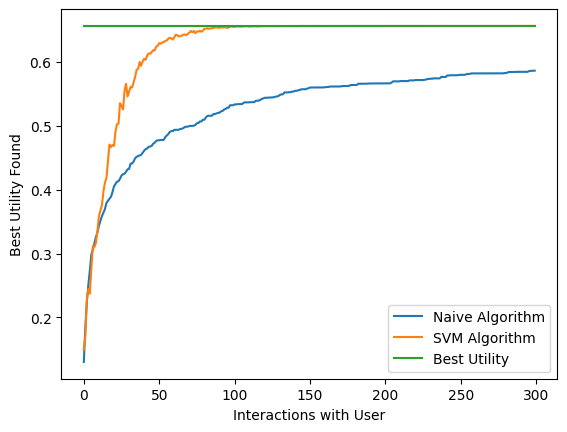

In [ ]:
plt.plot(np.mean(naiveperformance, axis=0), label="Naive Algorithm")
plt.plot(np.mean(algperformance, axis=0), label="SVM Algorithm")
plt.plot(np.ones((300,1))*np.mean(actual), label="Best Utility")
plt.xlabel("Interactions with User")
plt.ylabel("Best Utility Found")
plt.legend()
plt.show()

In the following cell, we create an environment with 1000 items and 20 dimensions, and compare the convergence of our algorithms. Here, *K*=5.

In [ ]:
n = 1000
d = 20

actual = []
alg = []
alg2 = []
naive = []
naiveperformance = []
algperformance = []

for trial in range(500):
  env = Environment(n, d)

  naivebest, naiveutil, naiveutils = naivealg4(env, 5, 50)
  best, util, utils = alg4(env, 5, 50)
  actual.append(env.max_util)
  alg.append(util)
  naive.append(naiveutil)
  naiveperformance.append(naiveutils)
  algperformance.append(utils)
print("Naive Best Util: ", np.mean(naive))
print("Algorithm v0 Best Util: ", np.mean(alg))
print("Actual Best Util: ", np.mean(actual))  

Naive Best Util:  0.581389832521097
Algorithm v0 Best Util:  0.6565133182538719
Actual Best Util:  0.6569311866830765


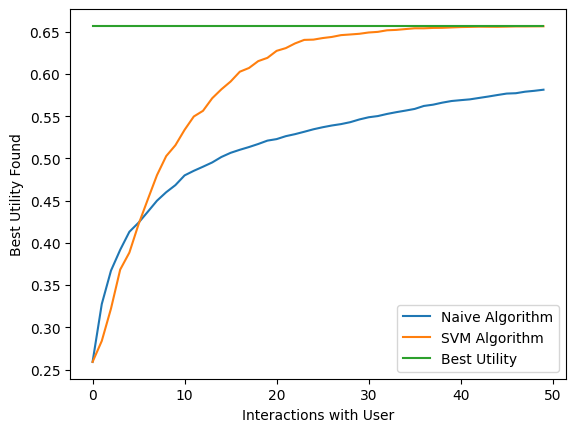

In [ ]:
plt.plot(np.mean(naiveperformance, axis=0), label="Naive Algorithm")
plt.plot(np.mean(algperformance, axis=0), label="SVM Algorithm")
plt.plot(np.ones((50,1))*np.mean(actual), label="Best Utility")
plt.xlabel("Interactions with User")
plt.ylabel("Best Utility Found")
plt.legend()
plt.show()